In [2]:
import numpy as np
import matplotlib.pyplot as plt

# classes to create, store and manage sudokus including a solver
from sudoku import Sudoku
from sudoku import Solver

# import of .png
import matplotlib.image as mpimg

# for manipulation of the sudoku images
import cv2

# DeepL libraries for image classification
from tensorflow.keras import backend as K
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D

#### To Do:
- comment and document code better
- Improve training set with 
    - more fonts
    - write function to center all the numbers in square arrays
    - translation of numbers
    - padding of numbers / zooming in
    - added noise
- improve edge detection
    - edgecase where border is close to edge of picture
    - or by using cv2.HoughLinesP
    - if edges != to 20 increase or decrease noise threshold and try again
- fill_squares function could be improved to work without grid thickness and square size. Rather find it out from the profile of the array (np.mean()).
- add functionality to detect degree of rotation of sudoku
- write CNN and train it
- if CNN unsure (below threshold) square is left empty (0)
- create proper solvable sudoku png to validate method

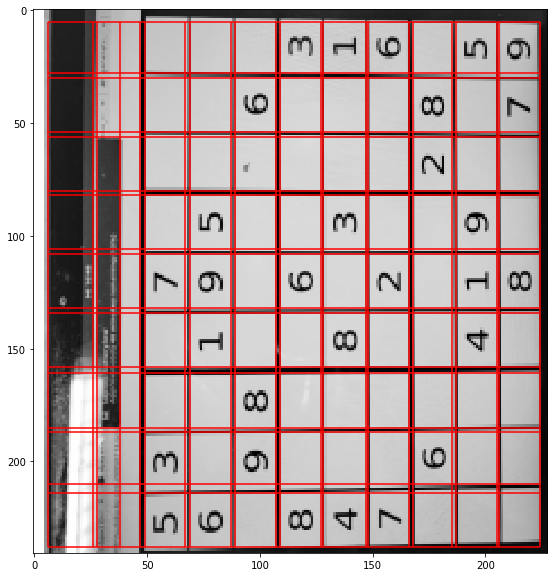

In [118]:
# functions to identify coordinates of the sudoku grid lines
def detect_edges(signal, noise_threshold=0.1):
    diff = np.diff(signal)
    diff[abs(diff) < noise_threshold] = 0
    diff[-1] = -1 # in order to detect sign change for last maximum
    sign_index = np.vstack([np.sign(diff), np.arange(0,diff.shape[0])])
    sign_index = sign_index[:,sign_index[0] != 0] # exclude all values that are below noise threshold
    signchange_indices = sign_index[1,:-1][sign_index[0][1:]*sign_index[0][:-1] < 0]
    return np.array(signchange_indices, dtype=int)

def square_coords(sudoku_containing_image,noise_threshold=0.1):
    try:
        sudoku_containing_image = sudoku_containing_image.reshape([256,256])
    except ValueError:
        pass
    vintensity = np.mean(sudoku_containing_image, axis=1)
    hintensity = np.mean(sudoku_containing_image, axis=0)
    bordersv = detect_edges(vintensity, noise_threshold)
    bordersh = detect_edges(hintensity, noise_threshold)
    return bordersv, bordersh

def segment_sudoku(sudoku_img, square_output_size):
    segments = np.zeros([square_output_size,square_output_size,9,9])
    vedges, hedges = square_coords(sudoku_img)
    for i in range(1,19,2):
        for j in range(1,19,2):
            subsquare = sudoku_img[vedges[i]+1:vedges[i+1],hedges[j]+1:hedges[j+1]]
            subsquare = cv2.resize(subsquare, (square_output_size, square_output_size), interpolation = cv2.INTER_AREA)
            segments[:,:,int((i-1)/2),int((j-1)/2)] = subsquare 
    return segments

def plot_segments(segments, fig_size=(10,10)):
    fig = plt.figure(figsize=fig_size)
    axes = fig.subplots(9,9)
    for i in range(9):
        for j in range(9):
            axes[i,j].imshow(segments[:,:,i,j], vmin=0, vmax=1)
            axes[i,j].set_xticklabels(())
            axes[i,j].set_yticklabels(())
    plt.show()


testim = mpimg.imread("testimg5.jpg")
testim = cv2.resize(testim, (256,256), interpolation = cv2.INTER_AREA)
testim = np.pad(cv2.cvtColor(testim, cv2.COLOR_BGR2GRAY)/255, pad_width=10, constant_values=1)
    

# segments = segment_sudoku(sudoku_img,28)
    
# plot_segments(segments)
mx = np.mean(testim, axis=0)
my = np.mean(testim, axis=1)
mx[abs(mx-np.mean(mx)) > 0.1] = 0
my[abs(my-np.mean(my)) > 0.1] = 0
startx = (np.argwhere(mx != 0))[0]
endx = (np.argwhere(mx != 0))[-1]
starty = (np.argwhere(my != 0))[0]
endy = (np.argwhere(my != 0))[-1]


# plt.figure(figsize=(10,10))
# plt.imshow(1-testim[int(starty)-5:int(endy)+5,int(startx)-5:int(endx)+5], cmap="Greys")
# plt.show()

sudoku_img = 1-testim[int(starty)-5:int(endy)+5,int(startx)-5:int(endx)+5]

plt.figure(figsize=(10,10))
plt.imshow(sudoku_img, cmap="Greys")
vedges, hedges = square_coords(sudoku_img, noise_threshold=0.08)
plt.hlines(vedges, xmax=max(hedges), xmin=min(hedges), color="red")
plt.vlines(hedges, ymax=max(vedges), ymin=min(vedges), color="red")
plt.show()
